# Find Signature Gene Profiles
```
Andrew E. Davidson
aedavids@ucsc.edu
```

We can use the profiles to deconvole bulk tissue and plasma sample

Data set: GTEx+TCGA 1vsAll results

ref:
- extraCellularRNA/terra/deseq/doc/plots
- extraCellularRNA/terra/deseq/doc/plots/jupyterNotebooks/GTExValidateExploration.ipynb
- https://support.terra.bio/hc/en-us/articles/360042259232-Managing-data-and-automating-workflows-with-the-FISS-API
- [An introduction to using the Fiss API in Python in BioData Catalyst](https://terra.biodatacatalyst.nhlbi.nih.gov/#workspaces/biodata-catalyst/BioData%20Catalyst%20Collection/notebooks/launch/Intro%20to%20FISS%20API%20in%20Python.ipynb)
- [upsetPlot](https://upsetplot.readthedocs.io/en/stable/api.html#upsetplot.plot)
- https://www.adamsmith.haus/python/answers/how-to-read-a-dictionary-from-a-file-in--python
- terra/jupyterNotebooks/exploreUpsetPlotInteresections.ipynb

## output
**best run on 2022-Aug-11 17:18:41**  
best critera was: 
```
    padjThreshold = 0.001
    lfcThreshold = 2.0
    n = 25
    sorted by absolute(log fold change)     
```

potenially we selected genes that had weak signals

- best 1 vs all results saved to  
    ```
    BUCKET='gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best/'
    ${BUCKET}/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25

    PRIVATE=/private/groups/kimlab/GTEx_TCGA/geneSignatureProfiles/best
    ${PRIVATE}/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25
    ```
    
- images and intersection.dict
    ```
    ${BUCKET}/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=*.png

    ${PRIVATE}/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2-.intersection.dict

    ${PRIVATE}/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--max_degree=*.png
    ```

**best 2023-Jul-16 21:20:57**  
best critera was: 
```
    padjThreshold = 0.001
    lfcThreshold = 2.0
    n = 25
    sorted by baseMean     
```

- best 1 vs all results saved to 
    ```
    BUCKET='gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best-sortedByBaseMean'
    ${BUCKET}/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25

    PRIVATE=/private/groups/kimlab/GTEx_TCGA/geneSignatureProfiles/best-sortedByBaseMean
    ${PRIVATE}/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25
    ```

- images and intersection.dict
    ```
    "${BUCKET}/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=*.png"
        
    ${PRIVATE}/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2-.intersection.dict

    ${PRIVATE}/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--max_degree=*.png
    ```
    
**tunning hints**
- there are a couple of class that do not have unique genes. Do they deconvole correctly? Most class have only 1 unique gene
    * 2022-Aug-11 17:18:41 when we sorted by padj instead of base me we can lots of unique genes in each class
- there are several genes test that are common to 30 + classes. Does eleminating these genes improve deconvolution results? 
    
## TODO
- implement  find down

## initialize

In [1]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%Y-%b-%d %H:%M:%S")
print("Run on ", current_time)

Run on  2023-Jul-16 21:20:57


In [2]:
from   firecloud import fiss
import firecloud.api as fapi
import io
from   matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from   pathlib import Path
#import upsetplot as upsp


# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display, Image

In [3]:
tmp = "./tmp"
!mkdir -p $tmp

In [4]:
# set env var used by fiss
# Get the Google billing project name and workspace name
billing_project = os.environ['WORKSPACE_NAMESPACE']
workspace = os.environ['WORKSPACE_NAME']
bucket = os.environ['WORKSPACE_BUCKET'] + "/"

print("Billing project: " + billing_project)
print("Workspace: " + workspace)
print("Workspace storage bucket: " + bucket)

Billing project: test-aedavids-proj
Workspace: uber
Workspace storage bucket: gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/


In [5]:
# Install a pip package in the current Jupyter kernel
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install --quiet upsetplot

# install upset plot
# see extraCellularRNA/terra/deseq/bin/createUpsetPlotZip.sh
url = bucket + "python/upsetPlot.zip"
! gsutil cp $url .
! unzip -o upsetPlot.zip > /dev/null
ORIG_PYTHONPATH = os.environ['PYTHONPATH']


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip
Copying gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/python/upsetPlot.zip...
/ [1 files][ 13.0 MiB/ 13.0 MiB]                                                
Operation completed over 1 objects/13.0 MiB.                                     


In [6]:
# setting the python path allows us to run python scripts from using
# the CLI. 
PYTHONPATH = ORIG_PYTHONPATH + ":./python"
os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}".format(PYTHONPATH))

# test install. We should get a help message
! python python/plots/geneSignatureUpsetPlot.py

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append(os.getcwd() + '/python')
print("\nsys.path:\n{}\n".format(sys.path))

from   plots.DESeqSelect import DESeqSelect
import upsetplot as upsp

PYTHONPATH: /etc/jupyter/custom:/usr/lib/spark/python:/home/jupyter/packages:./python
CALLING initializeLogging()
first call initialize Logging
CALLING initializeLogging()
usage: geneSignatureUpsetPlot.py [-h] [-t] [-w WIDTH] [-z HEIG] -d  -o  -c  -i
geneSignatureUpsetPlot.py: error: the following arguments are required: -d/--dataSetsCSV, -o/--outputFile, -c/--numThreads, -i/--intersectionOutputFile

sys.path:
['/home/jupyter/uber/edit', '/etc/jupyter/custom', '/usr/lib/spark/python', '/home/jupyter/packages', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/home/jupyter/.local/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jupyter/.ipython', '/home/jupyter/uber/edit/python']



In [7]:
outDir = "output"
! mkdir -p $outDir

outputImgDir = outDir + "/img"
! mkdir -p $outputImgDir

# Define select genes of interest functions 

In [8]:
def findUpRegulatedSignatureGenes(deseqDF, signatureGeneConfig):
    '''
    Find genes that that are statistically signifigant and up requlated
    
    arguments:
        deseqDF:
            results of DESeq2 as a pandas dataframe 
            
        signatureGeneConfig
            contains run parmeters            
            
    
    return:
        pandas dataframe
    '''
    selectSignificantRowsPS = deseqDF.loc[:,"padj"] < signatureGeneConfig.padjThreshold
#     print("number of genes with padj < {} : {}".format(padjThreshold,
#                                                        selectSignificantRowsPS.sum()))

    deseqLFCSignatureGenesDF = deseqDF.loc[ selectSignificantRowsPS,: ]\
                                        .sort_values("log2FoldChange", ascending=False)
    
    # find the genes that are over expresed 
    selectLFCPS = deseqLFCSignatureGenesDF.loc[:,"log2FoldChange"] >= signatureGeneConfig.lfcThreshold
#     print("number of genes with log2FoldChange >= {} = {}"\
#             .format( lfcThreshold, selectLFCPS.sum() ))
    
    deseqBaseMeanSignatureGenesDF = deseqLFCSignatureGenesDF.loc[ selectLFCPS,: ]\
                            .sort_values("baseMean", ascending=False)
    
    topSignatureGenesDF = deseqBaseMeanSignatureGenesDF.head( signatureGeneConfig.n )
    return topSignatureGenesDF

In [9]:
def runSelectGenesOfInterestFunction( signatureGeneConfig, candidateSignatureFileList,  skipRows=7 ):
    '''
    finds ups up regulated genes
    
    arguments:
        signatureGeneConfig
            contains run parmeters
            
        candidateSignatureFileList: 
            a list of file paths to candidate signature gene files to include in upset plot
            
            
        skipRows:
            int, default = 7
            1vsAll returns the results from DESeq with a self describing header comprised of 7 rows
            the lfcShrink output has 6 rows             
            
    returns: (upRegulatedDict, outFileList)
        upRegulatedDict : dictionary
            key: csgpFile name
            value: pandas dataframe
        
    '''
    retDict = {}
    retOutFileList = []
    for csgpFile in candidateSignatureFileList:
        deseqDF = pd.read_csv(csgpFile, skiprows=skipRows)
        #topSignatureGenesDF = findUpRegulatedSignatureGenes(deseqDF, signatureGeneConfig)
        signatureGenesDF = signatureGeneConfig.selectGenesOfInterestFunction(deseqDF, signatureGeneConfig)
                                                        

        fileName = csgpFile.split("/")[-1]
        outDir = signatureGeneConfig.getLocalCachedDir() 
        outFilePath = outDir + "/" + fileName
        signatureGenesDF.to_csv(outFilePath, index=False)
        print("saved to file: {}".format(outFilePath))

        retDict[fileName] = signatureGenesDF
        retOutFileList.append(outFilePath)

    
    return (retDict, retOutFileList)

# genesOfInterestDict, genesOfInterestFileList =  runSelectGenesOfInterestFunction(signatureGeneConfig, 
#                                                                    candidateSignatureFileList, 
#                                                                    skipRows=7)

In [10]:
def findBestSignatureGenesDepreciated(deseqDF, signatureGeneConfig):
    '''
    Find genes that that are statistically signifigant with  lfc <= -2.0 or >= 2.0
    
    arguments:
        deseqDF:
            results of DESeq2 as a pandas dataframe 
            
        signatureGeneConfig
            contains run parmeters
                signatureGeneConfig.padjThreshold
                signatureGeneConfig.lfcThreshold
            
    
    return:
        pandas dataframe
    '''    
    colsToReturn = deseqDF.columns
    
    #
    # find statistically signifigant genes
    #
    selectSignificantRowsPS = deseqDF.loc[:,"padj"] < signatureGeneConfig.padjThreshold
#     print("number of genes with padj < {} : {}".format(padjThreshold,
#                                                        selectSignificantRowsPS.sum()))

    #
    # use absolute value of log fold change to select best 
    # biologically signifigant genes
    # 
    significantDF = deseqDF.loc[selectSignificantRowsPS, :]
    absPS = significantDF['log2FoldChange'].abs()
    significantDF2 = significantDF.assign(absLog2FoldChange=absPS)    

    selectBestUpRegulatedRows = significantDF2.loc[:, 'absLog2FoldChange'] >= signatureGeneConfig.lfcThreshold
    significantDF3 = significantDF2.loc[selectBestUpRegulatedRows, :]
        
    #significantDF3 = significantDF3.sort_values( by = ['absLog2FoldChange'], ascending=False)

    return significantDF3.loc[:, colsToReturn].head(n=signatureGeneConfig.n)

In [11]:
def findBestSignatureGenes(deseqDF, signatureGeneConfig):
    '''
    Find genes that that are statistically signifigant with  lfc <= -2.0 or >= 2.0
    
    arguments:
        deseqDF:
            results of DESeq2 as a pandas dataframe 
            
        signatureGeneConfig
            contains run parmeters
                signatureGeneConfig.padjThreshold
                signatureGeneConfig.lfcThreshold
            
    
    return:
        pandas dataframe
    '''    
    colsToReturn = deseqDF.columns
    
    #
    # find statistically signifigant genes
    #
    selectSignificantRowsPS = deseqDF.loc[:,"padj"] < signatureGeneConfig.padjThreshold
    print("number of genes with padj < {} : {}".format(signatureGeneConfig.padjThreshold,
                                                       selectSignificantRowsPS.sum()))

    #
    # use absolute value of log fold change to select best 
    # biologically signifigant genes
    # 
    significantDF = deseqDF.loc[selectSignificantRowsPS, :]
    absPS = significantDF['log2FoldChange'].abs()
    significantDF2 = significantDF.assign(absLog2FoldChange=absPS)    

    selectBestUpRegulatedRows = significantDF2.loc[:, 'absLog2FoldChange'] >= signatureGeneConfig.lfcThreshold
    significantDF3 = significantDF2.loc[selectBestUpRegulatedRows, :]
        
    #significantDF3 = significantDF3.sort_values( by = ['absLog2FoldChange'], ascending=False)
    significantDF3 = significantDF3.sort_values( by = ['baseMean'], ascending=False)

    return significantDF3.loc[:, colsToReturn].head(n=signatureGeneConfig.n)


# Configure

In [12]:
class SignatureGeneConfig(object):
    '''
    Class used to keep track of all the parameters for a given data set
    
    should be treated as constant, immutable values
    '''
    
    def __init__(self, 
                 terraDataEntity, design, padjThreshold, lfcThreshold, n, 
                 selectGenesOfInterestFunction,
                 dataOutputBucketRoot,
                 localCacheRoot, title):
        '''
        arguments
            terraDataEntity:
                a name a terra workspace data model returned by listWorkspaceEntities.
                Expected to have a 'candidateSignatureGeneProfile' column
                
            Design:
                a string with the DESeq design. displayed on plots and encoded into data file names
                
            padjThreshold:
                selects genes with padj values <= padjThreshold
                
            lfcThreshold
            
            n: 
                type integer: 
                The number of rows to be select. 
                
            selectGenesOfInterestFunction:
                a function that takes in two arguments
                    deseqDF:
                        results of DESeq2 as a pandas dataframe
                        
                    signatureGeneConfig:
                        a configuration object 
                    
                example: findUpRegulatedSignatureGenes
                
            dataOutputBucketRoot
                example: gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/{up|down|best}
                location to store genes of interest
                
            localCacheRoot
                example: output
                
            title
                plot title       
                
        '''
        self.terraDataEntity = terraDataEntity
        self.design = design
        self.padjThreshold = padjThreshold
        self.lfcThreshold = lfcThreshold
        self.n = n
        self.selectGenesOfInterestFunction = selectGenesOfInterestFunction
        self.dataOutputBucketRoot = dataOutputBucketRoot
        self.localCacheRoot = localCacheRoot
        self.title = title
        
        localCache = self.getLocalCachedDir()
        ! mkdir -p $localCache
        
    def getfileNameBase(self):
        tmp = "{}-design:{}-padj:{}-lfc:{}-n:{}".format(
                                self.terraDataEntity,
                                self.design,
                                self.padjThreshold,
                                self.lfcThreshold, 
                                self.n
                                )
        return tmp.replace(" ","_")
        
    def saveGenesOfInterestToBucketURL(self):
        return self.dataOutputBucketRoot + "/" + self.getfileNameBase() 
    
    def getLocalCachedDir(self) :
        return self.localCacheRoot + "/" + self.getfileNameBase()

In [13]:
def createGTExTCGA_Config_top25():
    terraDataEntity = 'GTEx_TCGA_1vsAll'
    design = "~  gender + category"
    padjThreshold = 0.001
    lfcThreshold = 2.0
    n = 25
    selectGenesOfInterestFunction = findUpRegulatedSignatureGenes
    dataOutputBucketRoot = bucket + "data/1vsAll/up"
    localCacheRoot = outDir
    title = "{} topN={} Signature Genes, padj < {} lf2c > {} sorted by baseMean".format(terraDataEntity, 
                                                                                        n,
                                                                                        padjThreshold, 
                                                                                        lfcThreshold )
    
    GTExTCGA_Config_top25 = SignatureGeneConfig(
        terraDataEntity,
        design, 
        padjThreshold,
        lfcThreshold,
        n,
        selectGenesOfInterestFunction,
        dataOutputBucketRoot,
        localCacheRoot,
        title
    )
    
    return GTExTCGA_Config_top25

In [14]:
def createGTExTCGA_Config_best25():
    terraDataEntity = 'GTEx_TCGA_1vsAll'
    design = "~  gender + category"
    padjThreshold = 0.001
    lfcThreshold = 2.0
    n = 25
    selectGenesOfInterestFunction = findBestSignatureGenes
    dataOutputBucketRoot = bucket + "data/1vsAll/best-sortedByBaseMean"
    localCacheRoot = outDir
    title = "{} bestN={} Signature Genes, padj < {} lfc2 <= -{} or {} <= lfc2 ".format(terraDataEntity, 
                                                                                        n,
                                                                                        padjThreshold, 
                                                                                        lfcThreshold,
                                                                                        lfcThreshold)
    
    GTExTCGA_Config_best25 = SignatureGeneConfig(
        terraDataEntity,
        design, 
        padjThreshold,
        lfcThreshold,
        n,
        selectGenesOfInterestFunction,
        dataOutputBucketRoot,
        localCacheRoot,
        title
    )
    
    return GTExTCGA_Config_best25

In [15]:
GTExTCGA_Config_top25 = createGTExTCGA_Config_top25()
GTExTCGA_Config_best25 = createGTExTCGA_Config_best25()

# set signatureGeneConfig = to the data set you want to run
#signatureGeneConfig = GTExTCGA_Config_top25
signatureGeneConfig = GTExTCGA_Config_best25

print("title:\n{}\n".format(signatureGeneConfig.title))
print( "save to URL:\n{}\n".format(signatureGeneConfig.saveGenesOfInterestToBucketURL()))
print( "localCacheDir:\n{}".format(signatureGeneConfig.getLocalCachedDir()))

title:
GTEx_TCGA_1vsAll bestN=25 Signature Genes, padj < 0.001 lfc2 <= -2.0 or 2.0 <= lfc2 

save to URL:
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best-sortedByBaseMean/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25

localCacheDir:
output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25


# load 1vsAll results

In [16]:
def listWorkspaceEntities():
    '''
    prints out the names of all the workspace data models, and the number of rows in each model
    
    returns void
    '''
    # Take a look at all of the data models / entities in of our workspace
    ent_types = fiss.fapi.list_entity_types(billing_project, workspace).json()
    for t in ent_types.keys():
        print (t, "count:", ent_types[t]['count'])
        
listWorkspaceEntities()        

GTEx_TCGA_1vsAll_set count: 7
GTEx_1vsAll_set count: 2
GTEx_1vsAll count: 51
GTEx_TCGA_1vsAll count: 83
TCGA_1vsAll count: 32
design_b_category_GTEx_TCGA_1vsAll count: 83
design_b_category_GTEx_TCGA_1vsAll_set count: 2
TCGA_1vsAll_set count: 2


In [17]:
def loadTerraDataModel(billingProject, workspace, modelName) :
    '''
    makes the data models we would see on the terra uber workspace data tab.
    
    returns a pandas dataframe
    '''
    ret = pd.read_csv( io.StringIO(
                                    fiss.fapi.get_entities_tsv(
                                        billing_project, 
                                        workspace, 
                                        modelName,
                                        model='flexible')
                                    .text), 
                              sep='\t')
    return ret

# load the data model that has 1vsAll results
terraDataEntityDF = loadTerraDataModel(billing_project, workspace, signatureGeneConfig.terraDataEntity)
terraDataEntityDF

,entity:GTEx_TCGA_1vsAll_id,candidateSignatureGeneProfile,category,dataSet,estimatedSizeFactors
0,GTEx_Adipose_Subcutaneous,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Subcutaneous,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
1,GTEx_Adipose_Visceral_Omentum,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Visceral_Omentum,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
2,GTEx_Adrenal_Gland,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adrenal_Gland,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
3,GTEx_Artery_Aorta,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Aorta,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
4,GTEx_Artery_Coronary,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Coronary,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
...,...,...,...,...,...
78,TCGA_THCA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THCA,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
79,TCGA_THYM,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THYM,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
80,TCGA_UCEC,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCEC,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
81,TCGA_UCS,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCS,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...


In [18]:
def select1vsAllResults(df):
    '''
    select rows where candidateSignatureGeneProfile is not null
    
    returns a pandas dataframe
    '''
    selectRowsLogical = ~df.loc[:,'candidateSignatureGeneProfile'].isnull()
    retDF = df.loc[selectRowsLogical, :]
    
    return retDF  

In [19]:
# clean up. remove rows that are missing 1vsAll results
terraDataEntityDF = select1vsAllResults(terraDataEntityDF)
print("{}.shape:{}".format(signatureGeneConfig.terraDataEntity, terraDataEntityDF.shape))
assert terraDataEntityDF.shape[0] == 83, "ERROR: expected 83 candidateSignatureGeneProfiles"
#display( terraDataEntityDF.head() )

print("\n")
for f in terraDataEntityDF.loc[:,'candidateSignatureGeneProfile'].to_list():
    print( f.split("/")[-1] )

terraDataEntityDF

GTEx_TCGA_1vsAll.shape:(83, 5)


Adipose_Subcutaneous_vs_all.results
Adipose_Visceral_Omentum_vs_all.results
Adrenal_Gland_vs_all.results
Artery_Aorta_vs_all.results
Artery_Coronary_vs_all.results
Artery_Tibial_vs_all.results
Bladder_vs_all.results
Brain_Amygdala_vs_all.results
Brain_Anterior_cingulate_cortex_BA24_vs_all.results
Brain_Caudate_basal_ganglia_vs_all.results
Brain_Cerebellar_Hemisphere_vs_all.results
Brain_Cerebellum_vs_all.results
Brain_Cortex_vs_all.results
Brain_Frontal_Cortex_BA9_vs_all.results
Brain_Hippocampus_vs_all.results
Brain_Hypothalamus_vs_all.results
Brain_Nucleus_accumbens_basal_ganglia_vs_all.results
Brain_Putamen_basal_ganglia_vs_all.results
Brain_Spinal_cord_cervical_c-1_vs_all.results
Brain_Substantia_nigra_vs_all.results
Breast_Mammary_Tissue_vs_all.results
Cells_Cultured_fibroblasts_vs_all.results
Cells_EBV-transformed_lymphocytes_vs_all.results
Cervix_Endocervix_vs_all.results
Colon_Sigmoid_vs_all.results
Colon_Transverse_vs_all.results
Esophagus_Gast

,entity:GTEx_TCGA_1vsAll_id,candidateSignatureGeneProfile,category,dataSet,estimatedSizeFactors
0,GTEx_Adipose_Subcutaneous,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Subcutaneous,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
1,GTEx_Adipose_Visceral_Omentum,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Visceral_Omentum,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
2,GTEx_Adrenal_Gland,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adrenal_Gland,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
3,GTEx_Artery_Aorta,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Aorta,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
4,GTEx_Artery_Coronary,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Coronary,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
...,...,...,...,...,...
78,TCGA_THCA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THCA,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
79,TCGA_THYM,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THYM,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
80,TCGA_UCEC,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCEC,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
81,TCGA_UCS,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCS,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...


In [20]:
%%time
def downLoadCandidateSignatureGeneProfile(cache, dataModelDF):
    '''
    downloads candidateSignatureGeneProfile files to local disk if not already in local cache
    These files are the results created by running 1vsAll.wdl
    
    arguments:
        cache : 
            string path to director to store files location
        
        dataModelDF
            example, GTEx_1vsAllDF
            
    returns
        list of file path on local machine
    '''
    retList = []
    resultsList = dataModelDF.loc[:, 'candidateSignatureGeneProfile'].to_list()
    for gsURL in resultsList:
        fileName = gsURL.split("/")[-1]
        savePath = cache + "/" + fileName
        path = Path(savePath)
        if path.is_file() :
            print("skipping download of {}".format(fileName))            
        else:
            !gsutil -m cp $gsURL $savePath
            
        retList.append(savePath)
            
    return retList
            
        
candidateSignatureFileList = downLoadCandidateSignatureGeneProfile(tmp, terraDataEntityDF)

skipping download of Adipose_Subcutaneous_vs_all.results
skipping download of Adipose_Visceral_Omentum_vs_all.results
skipping download of Adrenal_Gland_vs_all.results
skipping download of Artery_Aorta_vs_all.results
skipping download of Artery_Coronary_vs_all.results
skipping download of Artery_Tibial_vs_all.results
skipping download of Bladder_vs_all.results
skipping download of Brain_Amygdala_vs_all.results
skipping download of Brain_Anterior_cingulate_cortex_BA24_vs_all.results
skipping download of Brain_Caudate_basal_ganglia_vs_all.results
skipping download of Brain_Cerebellar_Hemisphere_vs_all.results
skipping download of Brain_Cerebellum_vs_all.results
skipping download of Brain_Cortex_vs_all.results
skipping download of Brain_Frontal_Cortex_BA9_vs_all.results
skipping download of Brain_Hippocampus_vs_all.results
skipping download of Brain_Hypothalamus_vs_all.results
skipping download of Brain_Nucleus_accumbens_basal_ganglia_vs_all.results
skipping download of Brain_Putamen_basa

In [21]:
def testFindBestSignatureGenesDepreciated(signatureGeneConfig, candidateSignature, skipRows=7):
    print(candidateSignature)
    deseqDF = pd.read_csv(candidateSignature, skiprows=skipRows)
    return findBestSignatureGenesDepreciated(deseqDF, signatureGeneConfig)
     

# testResults = testFindBestSignatureGenesDepreciated(signatureGeneConfig, candidateSignatureFileList[0], skipRows=7)
# print("\n****** results")
# testResults

In [22]:
def testFindBestSignatureGenes(signatureGeneConfig, candidateSignature, skipRows=7):
    print(candidateSignature)
    deseqDF = pd.read_csv(candidateSignature, skiprows=skipRows)
    return findBestSignatureGenes(deseqDF, signatureGeneConfig)
     

# testResults = testFindBestSignatureGenes(signatureGeneConfig, candidateSignatureFileList[0], skipRows=7)
# print("\n****** results")
# testResults

# Find Genes of interest

In [23]:
genesOfInterestDict, genesOfInterestFileList =  runSelectGenesOfInterestFunction(signatureGeneConfig, 
                                                                   candidateSignatureFileList, 
                                                                   skipRows=7)

number of genes with padj < 0.001 : 25603
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Subcutaneous_vs_all.results
number of genes with padj < 0.001 : 24412
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Visceral_Omentum_vs_all.results
number of genes with padj < 0.001 : 22634
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adrenal_Gland_vs_all.results
number of genes with padj < 0.001 : 23960
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Aorta_vs_all.results
number of genes with padj < 0.001 : 18571
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Coronary_vs_all.results
number of genes with padj < 0.001 : 27161
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Tibial_vs_all.results
number of

In [24]:
%%time
# save to long term storage
URL_ROOT = signatureGeneConfig.saveGenesOfInterestToBucketURL() 
print("saving to: {}".format(URL_ROOT))
print()

for f in genesOfInterestFileList:
    print()
    baseName = f.split("/")[-1]
    url = URL_ROOT + "/" + baseName
    ! gsutil -m cp $f $url

saving to: gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best-sortedByBaseMean/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25


Copying file://output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Subcutaneous_vs_all.results [Content-Type=application/octet-stream]...
/ [1/1 files][  3.0 KiB/  3.0 KiB] 100% Done                                    
Operation completed over 1 objects/3.0 KiB.                                      

Copying file://output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Visceral_Omentum_vs_all.results [Content-Type=application/octet-stream]...
/ [1/1 files][  2.8 KiB/  2.8 KiB] 100% Done                                    
Operation completed over 1 objects/2.8 KiB.                                      

Copying file://output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adrenal_Gland_vs_all.results [Content-Type=application/octet-stream]...
/ [1

# Explore the genes of interest

In [25]:
for key in genesOfInterestDict.keys():
    df = genesOfInterestDict[key]
    print("\n" + key)
    display(df.head(n=2))


Adipose_Subcutaneous_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1838,MT-RNR2,774541.966032,-2.130825,0.082523,-25.820996,5.153263e-147,1.169894e-145
1518,MT-RNR1,140332.123897,-2.401196,0.088047,-27.271797,9.166201e-164,2.519287e-162



Adipose_Visceral_Omentum_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1749,MT-RNR1,140332.123897,-2.152879,0.09741,-22.101294,3.071370e-108,6.932522e-107
1478,FN1,122392.921176,-3.066497,0.13199,-23.232871,2.119686e-119,5.661096e-118



Adrenal_Gland_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
945,FN1,122392.921176,-4.267712,0.189822,-22.482648,6.136820e-112,2.561441e-110
1956,FLNA,94255.813936,-2.528567,0.134795,-18.758555,1.648210e-78,3.325476e-77



Artery_Aorta_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1261,MT-CO1,1.346880e+06,-2.422069,0.093130,-26.007299,4.094902e-149,1.316436e-147
1346,MT-ND4,9.479209e+05,-2.167527,0.084891,-25.533045,8.471896e-144,2.551695e-142



Artery_Coronary_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1489,MT-RNR2,774541.966032,-2.049810,0.136419,-15.025887,4.969188e-51,1.199142e-49
1046,MT-RNR1,140332.123897,-2.454292,0.145536,-16.863824,8.303822e-64,2.851693e-62



Artery_Tibial_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2178,MT-ND4,947920.929251,-2.045488,0.068751,-29.751918,1.637854e-194,3.126730e-193
2342,MT-RNR2,774541.966032,-2.400417,0.082446,-29.115192,2.305741e-186,4.093650e-185



Bladder_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
818,MT-RNR1,140332.123897,-2.537043,0.580581,-4.369836,0.000012,0.000443
939,KRT5,48084.270387,-5.115201,1.215352,-4.208823,0.000026,0.000796



Brain_Amygdala_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1506,MT-RNR2,774541.966032,2.601088,0.169930,15.306792,6.887865e-53,1.846103e-51
1159,MT-RNR1,140332.123897,2.944454,0.180956,16.271639,1.569016e-59,5.463286e-58



Brain_Anterior_cingulate_cortex_BA24_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4174,MT-RNR2,774541.966032,2.111731,0.158137,13.353771,1.126008e-40,1.121828e-39
3891,MT-RNR1,140332.123897,2.314849,0.168681,13.723260,7.367650e-43,7.874034e-42



Brain_Caudate_basal_ganglia_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2664,MT-RNR2,774541.966032,2.221928,0.133572,16.634744,3.904184e-62,6.097998e-61
2362,MT-RNR1,140332.123897,2.446625,0.142396,17.181795,3.634888e-66,6.402972e-65



Brain_Cerebellar_Hemisphere_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2924,ACTB,171303.433222,-2.055854,0.089289,-23.024653,2.640327e-117,3.811368e-116
1073,FN1,122392.921176,-6.383124,0.207399,-30.776954,5.331555e-208,2.096036e-206



Brain_Cerebellum_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2829,ACTB,171303.433222,-2.001157,0.084517,-23.677476,6.153533e-124,9.467961e-123
1177,FN1,122392.921176,-5.858127,0.196437,-29.821950,2.029089e-195,7.500223e-194



Brain_Cortex_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
739,FN1,122392.921176,-4.812845,0.190880,-25.213951,2.816511e-140,1.579453e-138
702,FLNA,94255.813936,-3.442597,0.135265,-25.450805,6.916084e-143,4.082556e-141



Brain_Frontal_Cortex_BA9_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
948,FN1,122392.921176,-4.845799,0.210272,-23.045377,1.636615e-117,7.158510e-116
159,FLNA,94255.813936,-4.390422,0.148675,-29.530349,1.174283e-191,3.046457e-189



Brain_Hippocampus_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1629,MT-RNR2,774541.966032,2.514353,0.149156,16.857198,9.288997e-64,2.372398e-62
1604,MT-RNR1,140332.123897,2.692087,0.159136,16.916941,3.375136e-64,8.754324e-63



Brain_Hypothalamus_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3231,MT-RNR2,774541.966032,2.080632,0.148028,14.055695,7.108111e-45,8.664769e-44
2387,MT-RNR1,140332.123897,2.452351,0.157598,15.560849,1.343060e-54,2.215823e-53



Brain_Nucleus_accumbens_basal_ganglia_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2889,MT-RNR2,774541.966032,2.293501,0.133893,17.12932,8.969736e-66,1.291642e-64
1975,MT-RNR1,140332.123897,2.716199,0.142298,19.08813,3.169134e-81,6.674428e-80



Brain_Putamen_basal_ganglia_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2127,MT-RNR2,774541.966032,2.441662,0.146223,16.698226,1.350191e-62,2.562888e-61
1879,MT-ND2,549933.369686,2.083296,0.120939,17.225951,1.696175e-66,3.644341e-65



Brain_Spinal_cord_cervical_c-1_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1108,FN1,122392.921176,-4.353446,0.242166,-17.977126,2.943603e-72,1.032676e-70
579,MBP,102582.489430,5.751208,0.281764,20.411467,1.322537e-92,8.871489e-91



Brain_Substantia_nigra_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2386,MT-RNR2,774541.966032,2.303201,0.177454,12.979169,1.606147e-38,2.705015e-37
2201,MT-RNR1,140332.123897,2.517651,0.189282,13.301081,2.281469e-40,4.165182e-39



Breast_Mammary_Tissue_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
884,MT-RNR2,774541.966032,-2.067373,0.098849,-20.914501,3.951408e-97,1.713929e-95
611,MT-RNR1,140332.123897,-2.389296,0.105447,-22.658652,1.146355e-113,7.190384e-112



Cells_Cultured_fibroblasts_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5117,MT-ND4,947920.929251,-2.233862,0.078595,-28.422613,1.062781e-177,8.935003e-177
4043,MT-RNR2,774541.966032,-2.962041,0.094009,-31.507948,6.760555e-218,7.193204e-217



Cells_EBV-transformed_lymphocytes_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
8715,MT-ND4,947920.929251,-2.074268,0.133835,-15.498720,3.538723e-54,1.653569e-53
10303,MT-RNR2,774541.966032,-2.192577,0.160309,-13.677216,1.389107e-42,5.490641e-42



Cervix_Endocervix_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
323,MT-ND1,425293.620441,-2.534453,0.577817,-4.386257,0.000012,0.000917
212,MT-RNR1,140332.123897,-3.362362,0.711223,-4.727579,0.000002,0.000275



Colon_Sigmoid_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1791,MT-RNR1,140332.123897,-2.040891,0.117065,-17.433813,4.569521e-68,1.001903e-66
1245,FLNA,94255.813936,2.123448,0.111491,19.045834,7.114389e-81,2.243431e-79



Colon_Transverse_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
48,KRT5,48084.270387,-7.727322,0.235209,-32.852965,1.033205e-236,8.115934e-234
1584,IGKC,45823.345403,3.217246,0.185982,17.298707,4.810681e-67,1.168221e-65



Esophagus_Gastroesophageal_Junction_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1764,FLNA,94255.813936,2.101194,0.111282,18.881779,1.610693e-79,3.473987e-78
2925,MYH11,76286.185370,2.820204,0.178221,15.824241,2.117370e-56,2.754752e-55



Esophagus_Mucosa_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2295,FN1,122392.921176,-3.381932,0.130294,-25.956219,1.546920e-148,2.819963e-147
1550,VIM,71448.838704,-2.354914,0.082379,-28.586312,9.941840e-180,2.682887e-178



Esophagus_Muscularis_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1703,FLNA,94255.813936,2.196068,0.094690,23.192091,5.471906e-119,1.261043e-117
6910,DES,89881.666167,2.284600,0.177467,12.873385,6.355426e-38,3.611309e-37



Heart_Atrial_Appendage_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5705,IGHG1,57607.938748,-2.587892,0.185426,-13.956449,2.874000e-44,2.059297e-43
433,KRT5,48084.270387,-6.600545,0.228575,-28.876978,2.323617e-183,2.188965e-181



Heart_Left_Ventricle_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
384,MT-CO1,1.346880e+06,2.914182,0.089488,32.564884,1.289087e-232,1.409559e-230
191,MT-ND4,9.479209e+05,2.861310,0.080816,35.405320,1.414157e-274,3.100686e-272



Kidney_Cortex_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
741,FN1,122392.921176,-3.986681,0.327177,-12.185091,3.732348e-34,1.791376e-32
2012,FLNA,94255.813936,-2.220481,0.232398,-9.554637,1.240177e-21,2.194060e-20



Liver_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1780,FLNA,94255.813936,-3.488922,0.143459,-24.319958,1.205761e-130,2.967622e-129
1405,DES,89881.666167,-6.817254,0.265601,-25.667234,2.715196e-145,8.465001e-144



Lung_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
843,MT-RNR2,774541.966032,-2.377409,0.088118,-26.979831,2.549070e-160,1.203227e-158
383,MT-RNR1,140332.123897,-2.992970,0.093822,-31.900395,2.636597e-223,2.735401e-221



Minor_Salivary_Gland_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
515,MT-RNR2,774541.966032,-2.641017,0.165820,-15.927008,4.115849e-57,2.907337e-55
742,MT-RNR1,140332.123897,-2.631493,0.177083,-14.860215,5.973340e-50,2.930313e-48



Muscle_Skeletal_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
223,ACTB,171303.433222,-2.267093,0.045479,-49.848893,0.0,0.0
1567,FN1,122392.921176,-4.409655,0.108206,-40.752276,0.0,0.0



Nerve_Tibial_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
917,MT-CO1,1.346880e+06,-2.379862,0.077934,-30.537081,8.393737e-205,3.718023e-203
573,MT-RNR2,7.745420e+05,-2.884068,0.084907,-33.967278,6.780112e-253,4.803130e-251



Ovary_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1160,MT-CO1,1.346880e+06,-2.611641,0.145475,-17.952508,4.587143e-72,1.512374e-70
2287,MT-ND4,9.479209e+05,-2.011556,0.132772,-15.150429,7.527357e-52,1.259319e-50



Pancreas_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2299,MT-RNR1,140332.123897,-2.620650,0.124490,-21.051136,2.232654e-98,4.083621e-97
822,FN1,122392.921176,-4.498348,0.168416,-26.709754,3.626118e-157,1.853506e-155



Pituitary_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1013,MT-CO1,1.346880e+06,-2.496488,0.115163,-21.677904,3.316398e-104,1.306412e-102
3878,MT-RNR1,1.403321e+05,-2.054880,0.134569,-15.270054,1.210724e-52,1.246743e-51



Prostate_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1271,MT-RNR1,140332.123897,-2.101547,0.144685,-14.524947,8.420790e-48,2.540338e-46
1700,FN1,122392.921176,-2.652012,0.196013,-13.529808,1.042951e-41,2.352803e-40



Skin_Not_Sun_Exposed_Suprapubic_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
494,FN1,122392.921176,-4.319693,0.124470,-34.704617,6.710979e-264,5.893188e-262
3050,FLNA,94255.813936,-2.119452,0.088644,-23.909612,2.433005e-126,3.466334e-125



Skin_Sun_Exposed_Lower_leg_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2869,MT-RNR2,774541.966032,-2.057811,0.080424,-25.58705,2.126119e-144,3.123468e-143
1149,FN1,122392.921176,-3.703781,0.116139,-31.89087,3.573601e-223,1.310207e-221



Small_Intestine_Terminal_Ileum_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1333,MT-RNR1,140332.123897,-2.165067,0.164990,-13.122378,2.451218e-39,7.135726e-38
1992,FN1,122392.921176,-2.654617,0.223496,-11.877708,1.545473e-32,3.011384e-31



Spleen_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3548,MT-RNR2,774541.966032,-2.203092,0.136350,-16.157607,1.003830e-58,1.133969e-57
3461,MT-RNR1,140332.123897,-2.378603,0.145552,-16.341954,4.963668e-60,5.748077e-59



Stomach_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2351,FN1,122392.921176,-2.374651,0.161962,-14.661792,1.132437e-48,1.795770e-47
15,PGA3,81308.952124,12.501654,0.255367,48.955704,0.000000e+00,0.000000e+00



Testis_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
8078,MT-ND5,217278.910505,-2.241327,0.09549,-23.471929,7.895232e-122,5.792280e-121
3898,ACTB,171303.433222,-2.259234,0.06887,-32.804257,5.120008e-236,7.783227e-235



Thyroid_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1001,MT-RNR2,774541.966032,-2.503443,0.082994,-30.164023,7.023958e-200,2.849049e-198
715,MT-RNR1,140332.123897,-2.860216,0.088521,-32.311225,4.865548e-229,2.761878e-227



Uterus_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1497,MT-CO1,1.346880e+06,-2.126138,0.163752,-12.983866,1.510582e-38,3.738539e-37
398,MT-RNR2,7.745420e+05,-3.097924,0.178442,-17.360928,1.630676e-67,1.515180e-65



Vagina_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
316,MT-RNR2,774541.966032,-2.435686,0.170071,-14.321609,1.603674e-46,1.828593e-44
298,MT-ND1,425293.620441,-2.126871,0.147422,-14.427079,3.495729e-47,4.225973e-45



Whole_Blood_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
10096,MT-CO1,1.346880e+06,-2.152827,0.070782,-30.414982,3.481285e-203,1.685098e-202
3030,HBB,9.850816e+05,11.377987,0.110899,102.597364,0.000000e+00,0.000000e+00



ACC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1526,MT-CO1,1.346880e+06,2.399273,0.215615,11.127558,9.212518e-29,2.227957e-27
1165,MT-ND4,9.479209e+05,2.352362,0.196427,11.975747,4.761281e-33,1.507970e-31



BLCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
731,CLU,56070.788880,-2.297242,0.121403,-18.922487,7.445740e-80,3.927933e-78
1259,C3,33138.986228,-2.246488,0.134593,-16.691018,1.523510e-62,4.669197e-61



BRCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2418,MYH11,76286.185370,-2.504476,0.119937,-20.881548,7.879672e-97,1.334723e-95
2579,KRT5,48084.270387,-3.343092,0.163862,-20.401848,1.610153e-92,2.557209e-91



CESC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2128,FN1,122392.921176,-2.529004,0.180456,-14.014526,1.270436e-44,2.238568e-43
2298,DES,89881.666167,-3.252320,0.236732,-13.738426,5.976102e-43,9.751523e-42



CHOL_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
182,DES,89881.666167,-5.853147,0.660142,-8.866499,7.548178e-19,1.399836e-16
19,KRT5,48084.270387,-9.875986,0.778573,-12.684727,7.186420e-37,1.219464e-33



COAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
32,CLU,56070.788880,-4.822089,0.148114,-32.556503,1.694015e-232,2.013003e-229
214,GPX3,40969.907575,-4.204779,0.162683,-25.846531,2.661677e-147,4.854651e-145



DLBC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4948,MT-ND2,549933.369686,-2.050964,0.251036,-8.169986,3.084257e-16,2.397232e-15
4496,MT-ND5,217278.910505,-2.210523,0.259778,-8.509261,1.750453e-17,1.497286e-16



ESCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1468,CLU,56070.788880,-3.172978,0.177939,-17.831859,3.999023e-71,1.121550e-69
2139,GPX3,40969.907575,-3.095799,0.194927,-15.881841,8.465630e-57,1.629792e-55



GBM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1577,DES,89881.666167,-4.587040,0.326412,-14.052912,7.392993e-45,1.851856e-43
2387,COL1A1,64196.089643,-2.827436,0.228624,-12.367187,3.933566e-35,6.510975e-34



HNSC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
8172,KRT13,59347.437558,3.472354,0.251711,13.795030,2.730407e-43,1.352909e-42
285,CLU,56070.788880,-3.559596,0.107398,-33.143962,6.919388e-241,9.797708e-239



KICH_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4100,MT-CO1,1.346880e+06,2.132551,0.239512,8.903749,5.399131e-19,5.029051e-18
2598,MT-ND4,9.479209e+05,2.270156,0.218074,10.410019,2.231770e-25,3.280162e-24



KIRC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2230,DES,89881.666167,-3.653735,0.177813,-20.548160,7.993523e-94,1.482044e-92
64,KRT5,48084.270387,-10.507501,0.208322,-50.438765,0.000000e+00,0.000000e+00



KIRP_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
432,DES,89881.666167,-5.279010,0.238815,-22.105006,2.828947e-108,2.548404e-106
1079,COL1A1,64196.089643,-3.101768,0.167249,-18.545838,8.811590e-77,3.182453e-75



LGG_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5303,FN1,122392.921176,-3.021494,0.137334,-22.001040,2.814504e-107,2.352637e-106
1400,MBP,102582.489430,5.266625,0.157830,33.369064,3.854477e-244,1.219786e-242



LIHC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
542,FTL,101725.794849,2.816165,0.086002,32.745221,3.551182e-235,2.815047e-233
4371,FLNA,94255.813936,-2.030850,0.114199,-17.783445,9.496141e-71,9.349312e-70



LUAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
261,DES,89881.666167,-4.153133,0.180200,-23.047413,1.561467e-117,2.267881e-115
388,CLU,56070.788880,-2.273153,0.107877,-21.071755,1.444750e-98,1.413293e-96



LUSC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
53,DES,89881.666167,-5.791090,0.183208,-31.609387,2.743427e-219,2.030695e-216
102,CLU,56070.788880,-3.161935,0.109496,-28.877267,2.304252e-183,8.942062e-181



MESO_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5244,DES,89881.666167,-2.337400,0.427143,-5.472177,4.445405e-08,3.045759e-07
794,GPX3,40969.907575,-2.961164,0.280086,-10.572354,4.003162e-26,1.808762e-24



OV_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
430,LSU-rRNA,432623.999254,3.099496,0.130274,23.792062,4.035478e-125,3.881642e-123
1325,SSU-rRNA,245645.018737,2.552032,0.141378,18.051069,7.737910e-73,2.419235e-71



PAAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
102,KRT5,48084.270387,-5.580854,0.355234,-15.710357,1.284545e-55,4.612139e-53
1138,KRT6A,36638.110998,-3.769981,0.394781,-9.549559,1.302500e-21,4.229065e-20



PCPG_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
6339,FN1,122392.921176,-2.471214,0.228767,-10.802334,3.355639e-27,2.034449e-26
3729,DES,89881.666167,-4.144376,0.299911,-13.818698,1.965928e-43,2.025907e-42



PRAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2436,FN1,122392.921176,-3.080970,0.143913,-21.408518,1.112958e-101,1.955325e-100
7701,DES,89881.666167,2.494366,0.188778,13.213254,7.357424e-40,4.089952e-39



READ_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
44,CLU,56070.788880,-4.691381,0.248042,-18.913682,8.799330e-80,7.238916e-77
4,KRT5,48084.270387,-12.100925,0.490062,-24.692638,1.283096e-134,9.500046e-131



SARC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3240,FLNA,94255.813936,2.049300,0.135270,15.149655,7.616550e-52,9.648883e-51
5213,DES,89881.666167,2.966324,0.250519,11.840692,2.404614e-32,1.893530e-31



SKCM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
949,DES,89881.666167,-5.272866,0.394328,-13.371779,8.840125e-41,3.554177e-39
2013,VIM,71448.838704,2.085380,0.190390,10.953200,6.414112e-28,1.217694e-26



STAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2109,LSU-rRNA,432623.999254,2.313742,0.114982,20.122683,4.671034e-90,9.507215e-89
908,SSU-rRNA,245645.018737,3.208417,0.121439,26.420084,8.055420e-154,3.805809e-152



TGCT_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1304,NEAT1,64887.67646,-2.147036,0.135960,-15.791712,3.548182e-56,1.121280e-54
1340,CLU,56070.78888,-3.284283,0.209653,-15.665346,2.610042e-55,8.026707e-54



THCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3699,FN1,122392.921176,2.557947,0.139062,18.394281,1.459847e-75,1.637515e-74
964,DES,89881.666167,-5.075769,0.183339,-27.685109,1.055144e-168,4.537996e-167



THYM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2263,MT-ND5,217278.910505,-2.003936,0.165318,-12.121697,8.106333e-34,1.421222e-32
359,DES,89881.666167,-6.701745,0.366132,-18.304157,7.666923e-75,8.453421e-73



UCEC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
773,FN1,122392.921176,-3.111808,0.233062,-13.351853,1.155386e-40,5.460018e-39
1685,KRT5,48084.270387,-4.041963,0.360722,-11.205194,3.845092e-29,8.341752e-28



UCS_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5811,DES,89881.666167,2.486514,0.532799,4.666894,3.057872e-06,1.965572e-05
922,MT-ND6,65672.670074,-2.144537,0.260471,-8.233300,1.821251e-16,7.371626e-15



UVM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2569,FN1,122392.921176,-4.396522,0.341164,-12.886839,5.338734e-38,7.654540e-37
1372,DES,89881.666167,-6.858493,0.448061,-15.307038,6.861797e-53,1.841540e-51


## create dataSet.csv
This file is an argument to plots/geneSignatureUpsetPlot.py. I defines the set of candidate genes to include
in the upset plot

In [26]:
def createDataSetCSV(csgpFileList):
    retDF = None
    for csgp in csgpFileList:
        setName = csgp.split("/")[-1]
        filePath = csgp
        numHeaderLines = 8

        tmpDF = pd.DataFrame( {"setName":[setName], 'numHeaderLines':[numHeaderLines], 'filePath':[filePath]} )
        if retDF is None:
            retDF = tmpDF
        else:
            byRows = 0
            retDF = pd.concat([retDF, tmpDF], axis=byRows, ignore_index=True)
            
    return retDF
        
def saveDataSetDF(genesOfInterestFileList):
    dataSetDF = createDataSetCSV(genesOfInterestFileList)
    dataSetPaths = signatureGeneConfig.getLocalCachedDir() + "/dataSets.csv"
    dataSetDF.to_csv(dataSetPaths , index=False)
    print("saved dataSetPaths to: {}".format(dataSetPaths))
    #dataSetDF
    return dataSetPaths

dataSetPaths = saveDataSetDF(genesOfInterestFileList)

saved dataSetPaths to: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/dataSets.csv


## Create Upset Plot Data

In [27]:
def createGeneSets(dataSetPaths):
    '''
    arguments: 
        dataSetPaths: a csv file with cols 'setName,numHeaderLines,filePath'
        
    returns:
        (geneSetsDict, geneSetsDESeqDict)
        
        geneSetsDict can be passed to upsetplot.from_contents()
        geneSetsDESeqDict contains DESeq result value for genes in the intersections
        
    '''
    
    dataSetsDF = pd.read_csv( dataSetPaths )
    print("dataSetsDF.shape:{}".format(dataSetsDF.shape))
    print("dataSetsDF.columns: {}".format(dataSetsDF.columns))
    
    geneSetsDict = {} 
    geneSetsDESeqDict = {} 
    
    numFiles = dataSetsDF.shape[0]

    for i in range(numFiles):
        tissueId = dataSetsDF.iloc[i,0]
        tissueId = tissueId.replace('_vs_all.results', '')
        numHeaderLines = dataSetsDF.iloc[i,1]
        file = dataSetsDF.iloc[i,2]

        #tokens = file.split(".")
        isHack = False
        if "lfcShrink" in file:
            isHack = True

        print("processing setId:{} numHeaderLines:{} file: {}".format(tissueId, numHeaderLines, file))
        # tokens = file.split("/")
        # #print(tokens)
        #
        # # last token: signatureGenesValidateThyroid.csv
        # fileName = tokens[-1].split(".")[0]
        # #print(fileName)
        # tissueId = fileName[ len( "signatureGenesValidate" ):]
        # print(tissueId)
        dataLoader = DESeqSelect( file )

        if isHack:
            geneNamesNP, baseMeanNP, xlog2FoldChangeNP, yNeglog10pValueNP = dataLoader.readVolcanoPlotData(numHeaderLines, hackPadjIndx=5)
        else:
            geneNamesNP, baseMeanNP, xlog2FoldChangeNP, yNeglog10pValueNP = dataLoader.readVolcanoPlotData(numHeaderLines)

        geneSetsDict[tissueId] = set( geneNamesNP )

        # hold on to deseq results Data so that we can analyze signature gene sets with overlapping genes
        geneSetsDESeqDict[tissueId] = {
            "inputFile":file,
            # key is geneName
            "deseqResultSet": dataLoader.loadDESeqResultsAsStrings(numHeaderLines)
        }   

    return (geneSetsDict, geneSetsDESeqDict)


geneSetsDict, geneSetsDESeqDict = createGeneSets( dataSetPaths )

dataSetsDF.shape:(83, 3)
dataSetsDF.columns: Index(['setName', 'numHeaderLines', 'filePath'], dtype='object')
processing setId:Adipose_Subcutaneous numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Subcutaneous_vs_all.results
processing setId:Adipose_Visceral_Omentum numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Visceral_Omentum_vs_all.results
processing setId:Adrenal_Gland numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adrenal_Gland_vs_all.results
processing setId:Artery_Aorta numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Aorta_vs_all.results
processing setId:Artery_Coronary numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Coronary_vs_all.results
processing setId:Artery_Tibial numHeaderLines:8 file: out

In [28]:
print("small sample of DESeq results for genes of interest")
i = 0
for key,item in geneSetsDESeqDict.items():
    print("\nkey:{} item:{}".format(key,item.keys()))
    itemDict = item['deseqResultSet']
    for k,ii in itemDict.items():
        s = [ "{0:0.2f}".format(float(g)) for g in ii ]
        print("\tgene:{} ii:{}".format(k,  s))
        
    i += 1
    if i >= 2:
        break

small sample of DESeq results for genes of interest

key:Adipose_Subcutaneous item:dict_keys(['inputFile', 'deseqResultSet'])
	gene:KRT6A ii:['36638.11', '-6.51', '0.21', '-31.67', '0.00', '0.00']
	gene:HSPA1A ii:['28373.76', '-2.14', '0.09', '-24.70', '0.00', '0.00']
	gene:IGHA1 ii:['25988.00', '-4.43', '0.15', '-29.41', '0.00', '0.00']
	gene:HSPA1B ii:['22315.73', '-2.18', '0.08', '-26.40', '0.00', '0.00']
	gene:KRT17 ii:['19620.98', '-3.94', '0.16', '-24.00', '0.00', '0.00']
	gene:SCD ii:['19314.42', '2.34', '0.10', '23.00', '0.00', '0.00']
	gene:CD24 ii:['17904.27', '-5.45', '0.13', '-42.75', '0.00', '0.00']
	gene:KRT8 ii:['17718.51', '-3.97', '0.12', '-33.78', '0.00', '0.00']
	gene:FASN ii:['16799.56', '2.53', '0.08', '31.32', '0.00', '0.00']
	gene:PERP ii:['16019.98', '-2.23', '0.11', '-19.41', '0.00', '0.00']
	gene:ADH1B ii:['15806.77', '2.57', '0.14', '18.63', '0.00', '0.00']
	gene:TGM2 ii:['15220.50', '-2.01', '0.10', '-20.87', '0.00', '0.00']
	gene:SERPINA3 ii:['14604.19', '-

In [29]:
# create up set plot data
geneSetsUpsetPlotData = upsp.from_contents(geneSetsDict)

## Create Upset Plot

In [30]:
def configurablePlot(signatureGeneConfig, geneSetsUpsetPlotData, **kwags):
    '''
    return 
        (fig, pltDict)
    
    allows you to pass extra upset plot variables
    examples
        configurablePlot(geneSetsUpsetPlotData, show_counts=True, min_degree=4)
        configurablePlot(geneSetsUpsetPlotData, show_counts=True, min_degree=4, max_degree=7)
    '''
    pltDict = upsp.UpSet(geneSetsUpsetPlotData,  **kwags).plot()
    fig = plt.gcf()
    title = signatureGeneConfig.title
    fig.suptitle( title, fontsize=40 ) 
    
    return (fig, pltDict)

In [31]:
def findIntersectionElements(geneSetsDict, geneSetsUpsetPlotData):
    '''
    arguments:
        geneSetsDict
            key: set name
            value is a list of elements
        
        geneSetsUpsetPlotData:
            pandas multilevel index data frame. created from a function like upsetPlot from_contents()
            
    returns:
        retDict
            key: a comma separated list of set name
            value: the name of the elements in the intersection
            
        retSingleSetDict
            key: set name
            value: list of unique elements. elements not in any intersections
    '''
    retDict = dict()
    retSingleSetDict = dict()
    
    # convert list to numpy array so we can use fancy array index
    setNames = list(geneSetsUpsetPlotData.index.names)
    setNamesNP = np.asarray(setNames)
    
    # for each intersection 
    for idx in geneSetsUpsetPlotData.index.values:
        #print("\n********")
        arrayNP = np.asarray(idx)
        
        # get the list of sets that the intersection was formed from 
        setNameList = sorted( setNamesNP[arrayNP] )
        setList = list()
        for sn in setNameList:
            setList.append( geneSetsDict[sn] )
            
        if len(setList) > 1:
            intersection = set.intersection( *setList )
            #print(intersection)
            key = ",".join(setNameList)
            retDict[ key ] = intersection
            
    # find elements that are not in an intersection
    n = len(setNamesNP)
    for i in range(0, n):
        testSetName = setNamesNP[i]
        knockOut = [True]*n 
        knockOut[i] = False # the name to knock out
        unionSetNameList = setNamesNP[ knockOut ]
        
        unionSetList = list()
        for u in unionSetNameList:
            unionSetList.append( geneSetsDict[u] )
            
        union = set.union( *unionSetList )
        testSet = geneSetsDict[testSetName]
        intersection = testSet.difference(union)
        
        if len(intersection) > 0:
            retSingleSetDict[testSetName] = intersection 
            
    return (retDict, retSingleSetDict)

In [32]:
def getBaseName(signatureGeneConfig):
    # remove chars that can not be used in file names
    baseName =  signatureGeneConfig.title.replace(" ", "-")
    baseName = baseName.replace("<", "lt")
    baseName = baseName.replace(">", "gt")
    return baseName
    
def savePlot(fig, signatureGeneConfig, extraFileNameParts):
    # remove chars that can not be used in file names
#     baseName =  signatureGeneConfig.title.replace(" ", "-")
#     baseName = baseName.replace("<", "lt")
#     baseName = baseName.replace(">", "gt")
    baseName = getBaseName( signatureGeneConfig )
    baseName = baseName + "-" + extraFileNameParts
    
    # save png
    fileName = baseName + ".png"
    filePath = signatureGeneConfig.localCacheRoot + "/" + fileName

    ! rm $filePath 
    print("saving to: {}".format(filePath))
    fig.savefig(filePath, dpi=300, bbox_inches='tight', facecolor='white')

    imgURL = signatureGeneConfig.saveGenesOfInterestToBucketURL() + fileName
    print("save to :\n{}".format(imgURL))
    ! gsutil cp $filePath $imgURL    

In [33]:
def saveInteresection(signatureGeneConfig, intersectionElementsDict):
    baseName = getBaseName( signatureGeneConfig )    
    
    # https://www.adamsmith.haus/python/answers/how-to-read-a-dictionary-from-a-file-in--python
    fileName =  baseName + ".intersection.dict"
    filePath = signatureGeneConfig.localCacheRoot + "/" + fileName
    with open(filePath,'w') as data: 
      data.write(str(intersectionElementsDict))
    
    intersectionURL = signatureGeneConfig.saveGenesOfInterestToBucketURL() + fileName
    print("save to :\n{}".format(intersectionURL))
    ! gsutil cp $filePath $intersectionURL   

In [34]:
# for each interesection save the list of sets in the intersection and the 
# intersection elements for down stream analysis
intersectionElementsDict, retSingleSetDict  = findIntersectionElements(geneSetsDict, geneSetsUpsetPlotData)
intersectionElementsDict.update(retSingleSetDict)
saveInteresection(signatureGeneConfig, intersectionElementsDict)

# organize intersections so we can print the intersections for each plot
setDegreesDict = dict()
for setNames,elements in intersectionElementsDict.items():
    numSetsInIntersection = len(setNames.split(","))
    if numSetsInIntersection in setDegreesDict:
        d = setDegreesDict[numSetsInIntersection]
    else :
        d = dict()
        setDegreesDict[numSetsInIntersection] = d
        
    d = setDegreesDict[numSetsInIntersection]
    d[setNames] = elements
      
        
def printInserectionElements(setDegreesDict, testFunction):
    sortedKeys = sorted(setDegreesDict.keys(), reverse=True)
    #print(sortedKeys)
    for key in sortedKeys:
        #if key >=4:
        if testFunction(key) :
            d = setDegreesDict[key]
            n = len(d.keys())
            print("\n############### degree: {} number of intersections:{}".format(key, n))
            for setName, elements in d.items():
                print("\nsetName:{}\n elements:\n{}".format(setName, elements))

save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best-sortedByBaseMean/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2-.intersection.dict
Copying file://output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2-.intersection.dict [Content-Type=application/octet-stream]...
/ [1 files][ 24.5 KiB/ 24.5 KiB]                                                
Operation completed over 1 objects/24.5 KiB.                                     


### upset plot max_degree = 1

rm: cannot remove 'output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--max_degree=1.png': No such file or directory
saving to: output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--max_degree=1.png
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best-sortedByBaseMean/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--max_degree=1.png
Copying file://output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--max_degree=1.png [Content-Type=image/png]...
/ [1 files][  2.8 MiB/  2.8 MiB]                                                
Operation completed over 1 objects/2.8 MiB.                                      


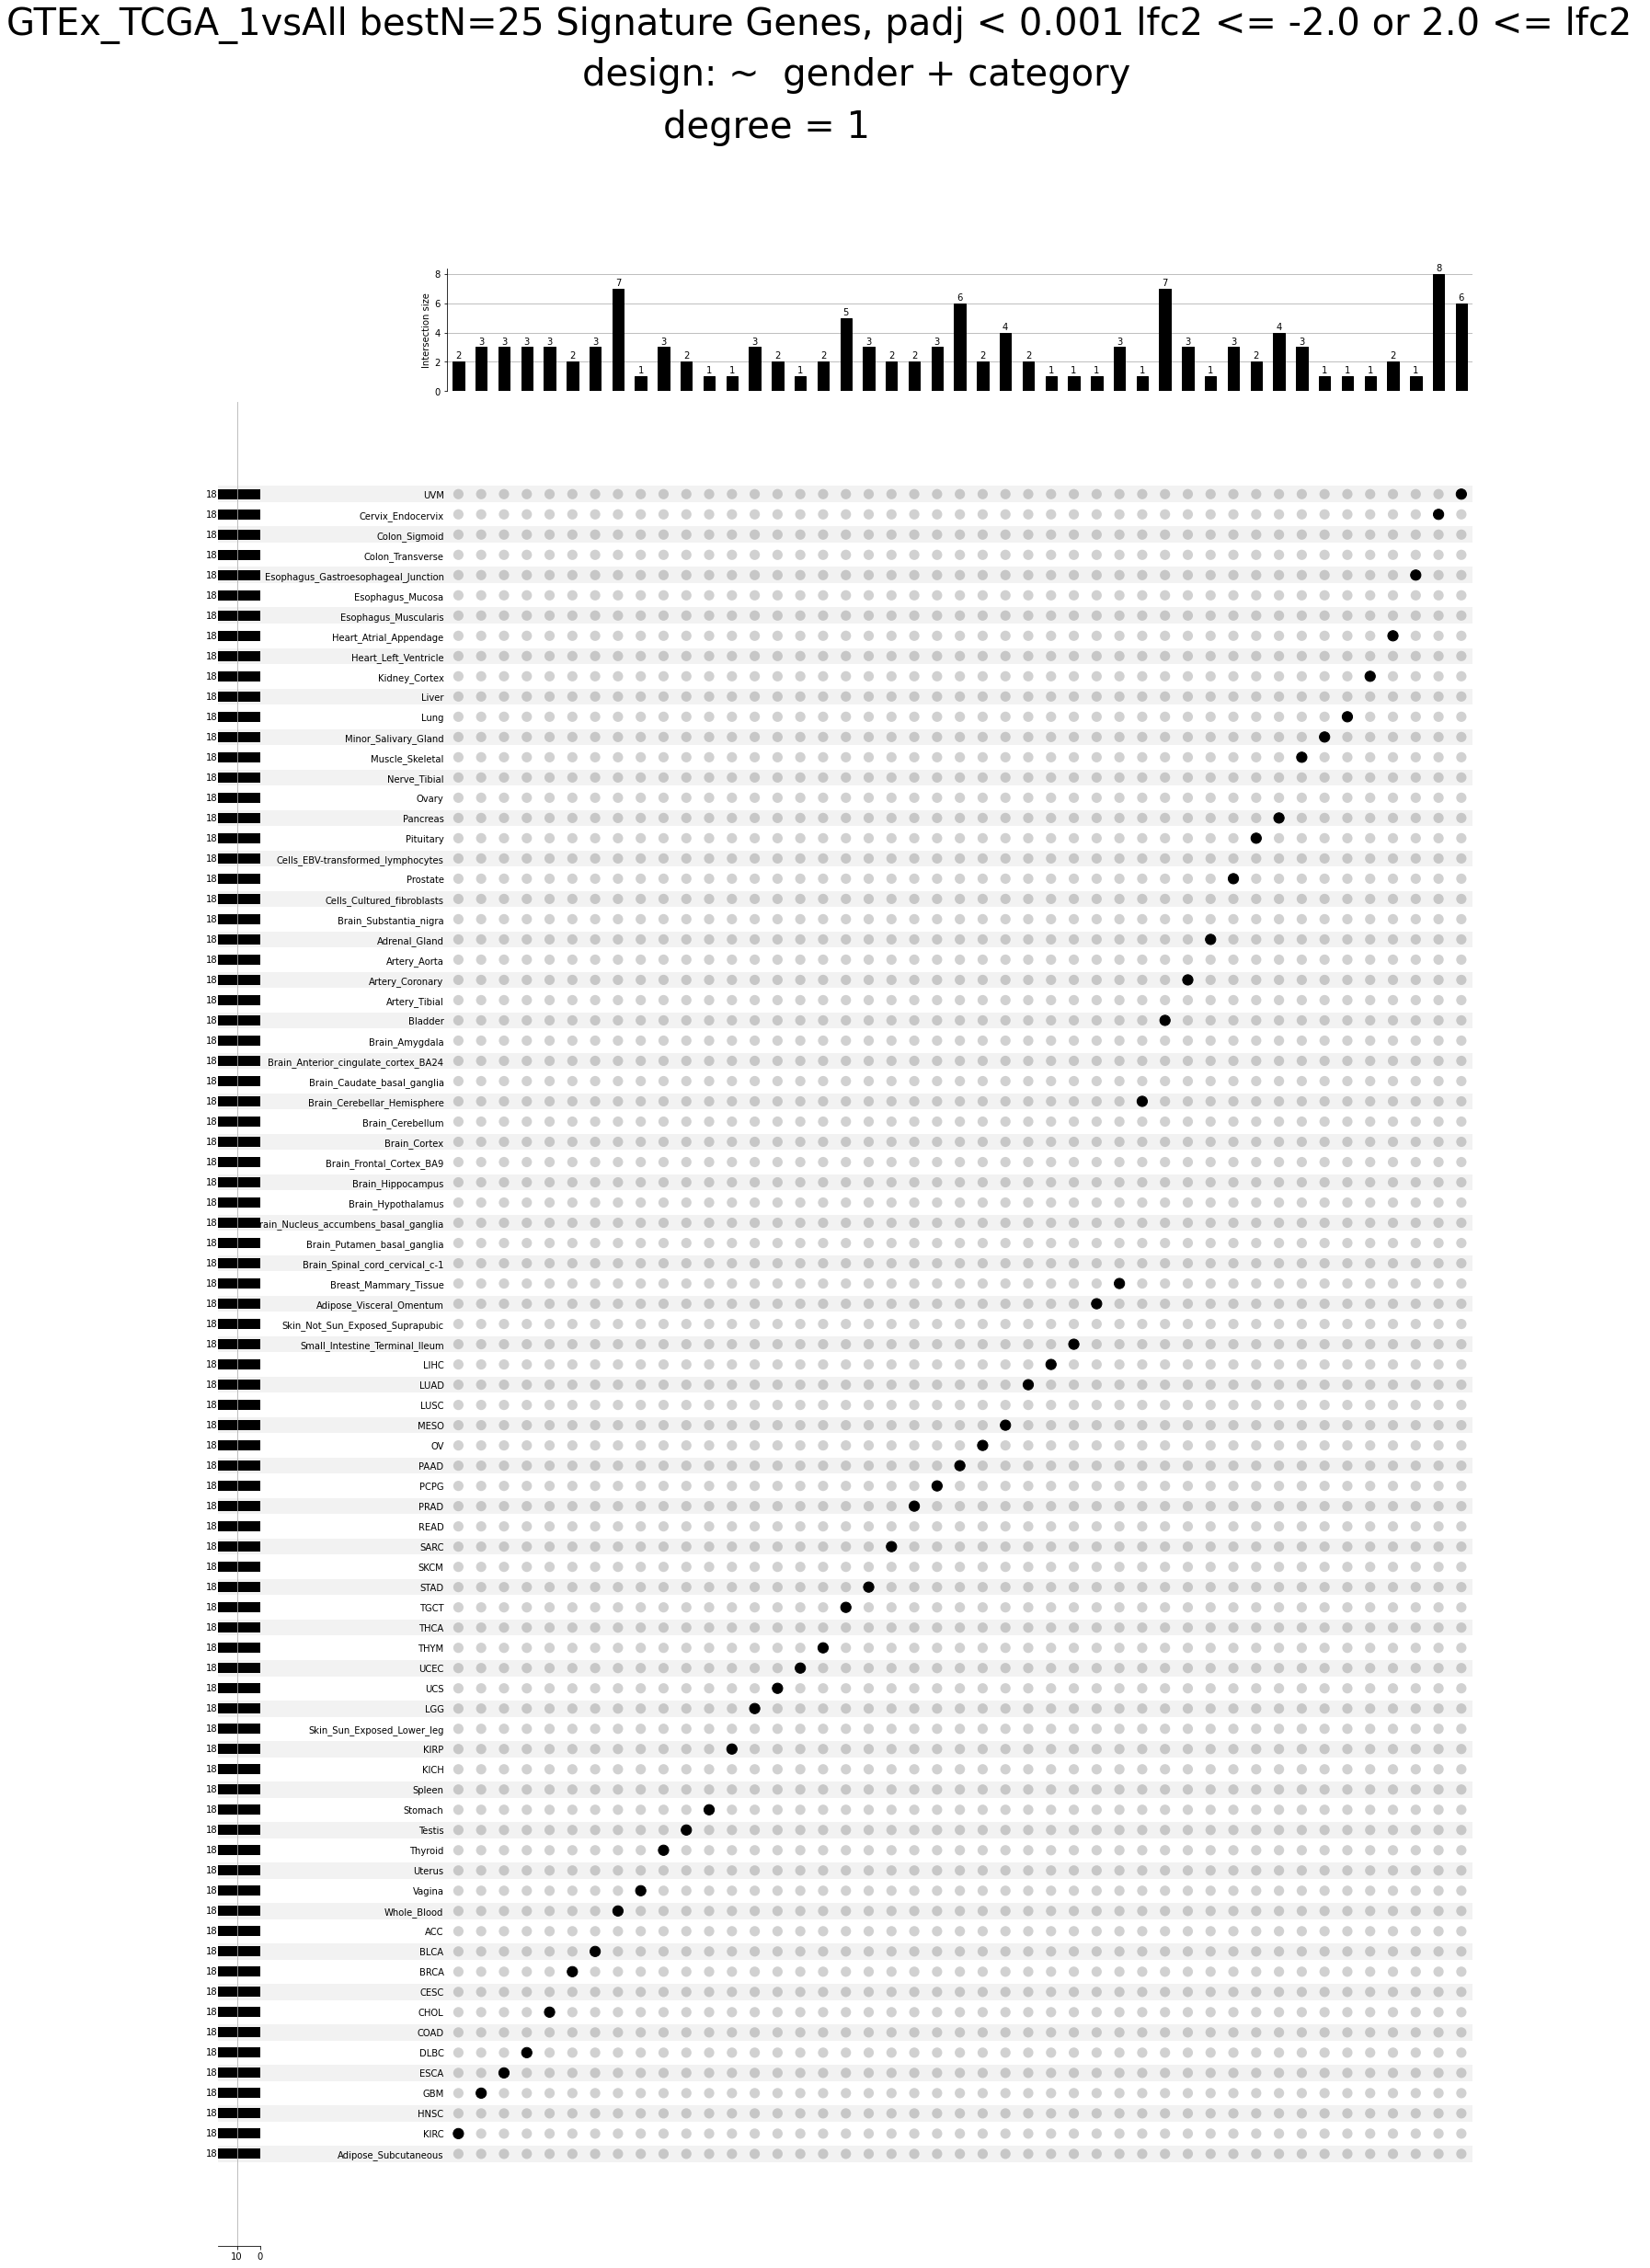

In [35]:
# create a plot sets of genes that are only found in one type
# use extra args to insure saved file name is unique
extraFileNameParts = 'max_degree=1'
fig, pltDict = configurablePlot(signatureGeneConfig, geneSetsUpsetPlotData, show_counts=True, max_degree=1)

# add more text to plot
designStr = "design: {}".format(signatureGeneConfig.design)
# hack to find text positions
fig.text(x=0.35, y=0.95, s=designStr, fontsize=40 )
fig.text(x=0.40, y=0.93, s="degree = 1", fontsize=40)

savePlot(fig, signatureGeneConfig, extraFileNameParts)

### upset plot max_degree = 1 intersection elements

In [36]:
def testFunction(key):
    return key == 1
                
printInserectionElements(setDegreesDict, testFunction)


############### degree: 1 number of intersections:45

setName:Adipose_Visceral_Omentum
 elements:
{'EGR1'}

setName:Adrenal_Gland
 elements:
{'H19'}

setName:Artery_Coronary
 elements:
{'TIMP1', 'PRELP', 'MFGE8'}

setName:Bladder
 elements:
{'PLEKHB1', 'CEACAM5', 'AGT', 'ALDOC', 'MT1X', 'SPOCK2', 'STMN1'}

setName:Brain_Cerebellar_Hemisphere
 elements:
{'RPS2'}

setName:Breast_Mammary_Tissue
 elements:
{'OBSCN', 'DKK3', 'PLIN4'}

setName:Cervix_Endocervix
 elements:
{'CEACAM6', 'LPL', 'HOPX', 'NEBL', 'FOSB', 'SLC25A4', 'TUBA4A', 'CD36'}

setName:Esophagus_Gastroesophageal_Junction
 elements:
{'SMTN'}

setName:Heart_Atrial_Appendage
 elements:
{'NPPA', 'MYH6'}

setName:Kidney_Cortex
 elements:
{'LRP1'}

setName:Lung
 elements:
{'EPAS1'}

setName:Minor_Salivary_Gland
 elements:
{'MUC7'}

setName:Muscle_Skeletal
 elements:
{'CKM', 'TTN', 'ACTA1'}

setName:Pancreas
 elements:
{'PNLIP', 'PRSS1', 'CPA1', 'PRSS2'}

setName:Pituitary
 elements:
{'GNAS', 'HLA-E'}

setName:Prostate
 elements:
{

### upset plot: min_degree = 2 max_degree = 3

rm: cannot remove 'output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=2,max_degree=3.png': No such file or directory
saving to: output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=2,max_degree=3.png
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best-sortedByBaseMean/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=2,max_degree=3.png
Copying file://output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=2,max_degree=3.png [Content-Type=image/png]...
/ [1 files][  3.5 MiB/  3.5 MiB]                                                
Operation completed over 1 objects/3.5 MiB.                                      


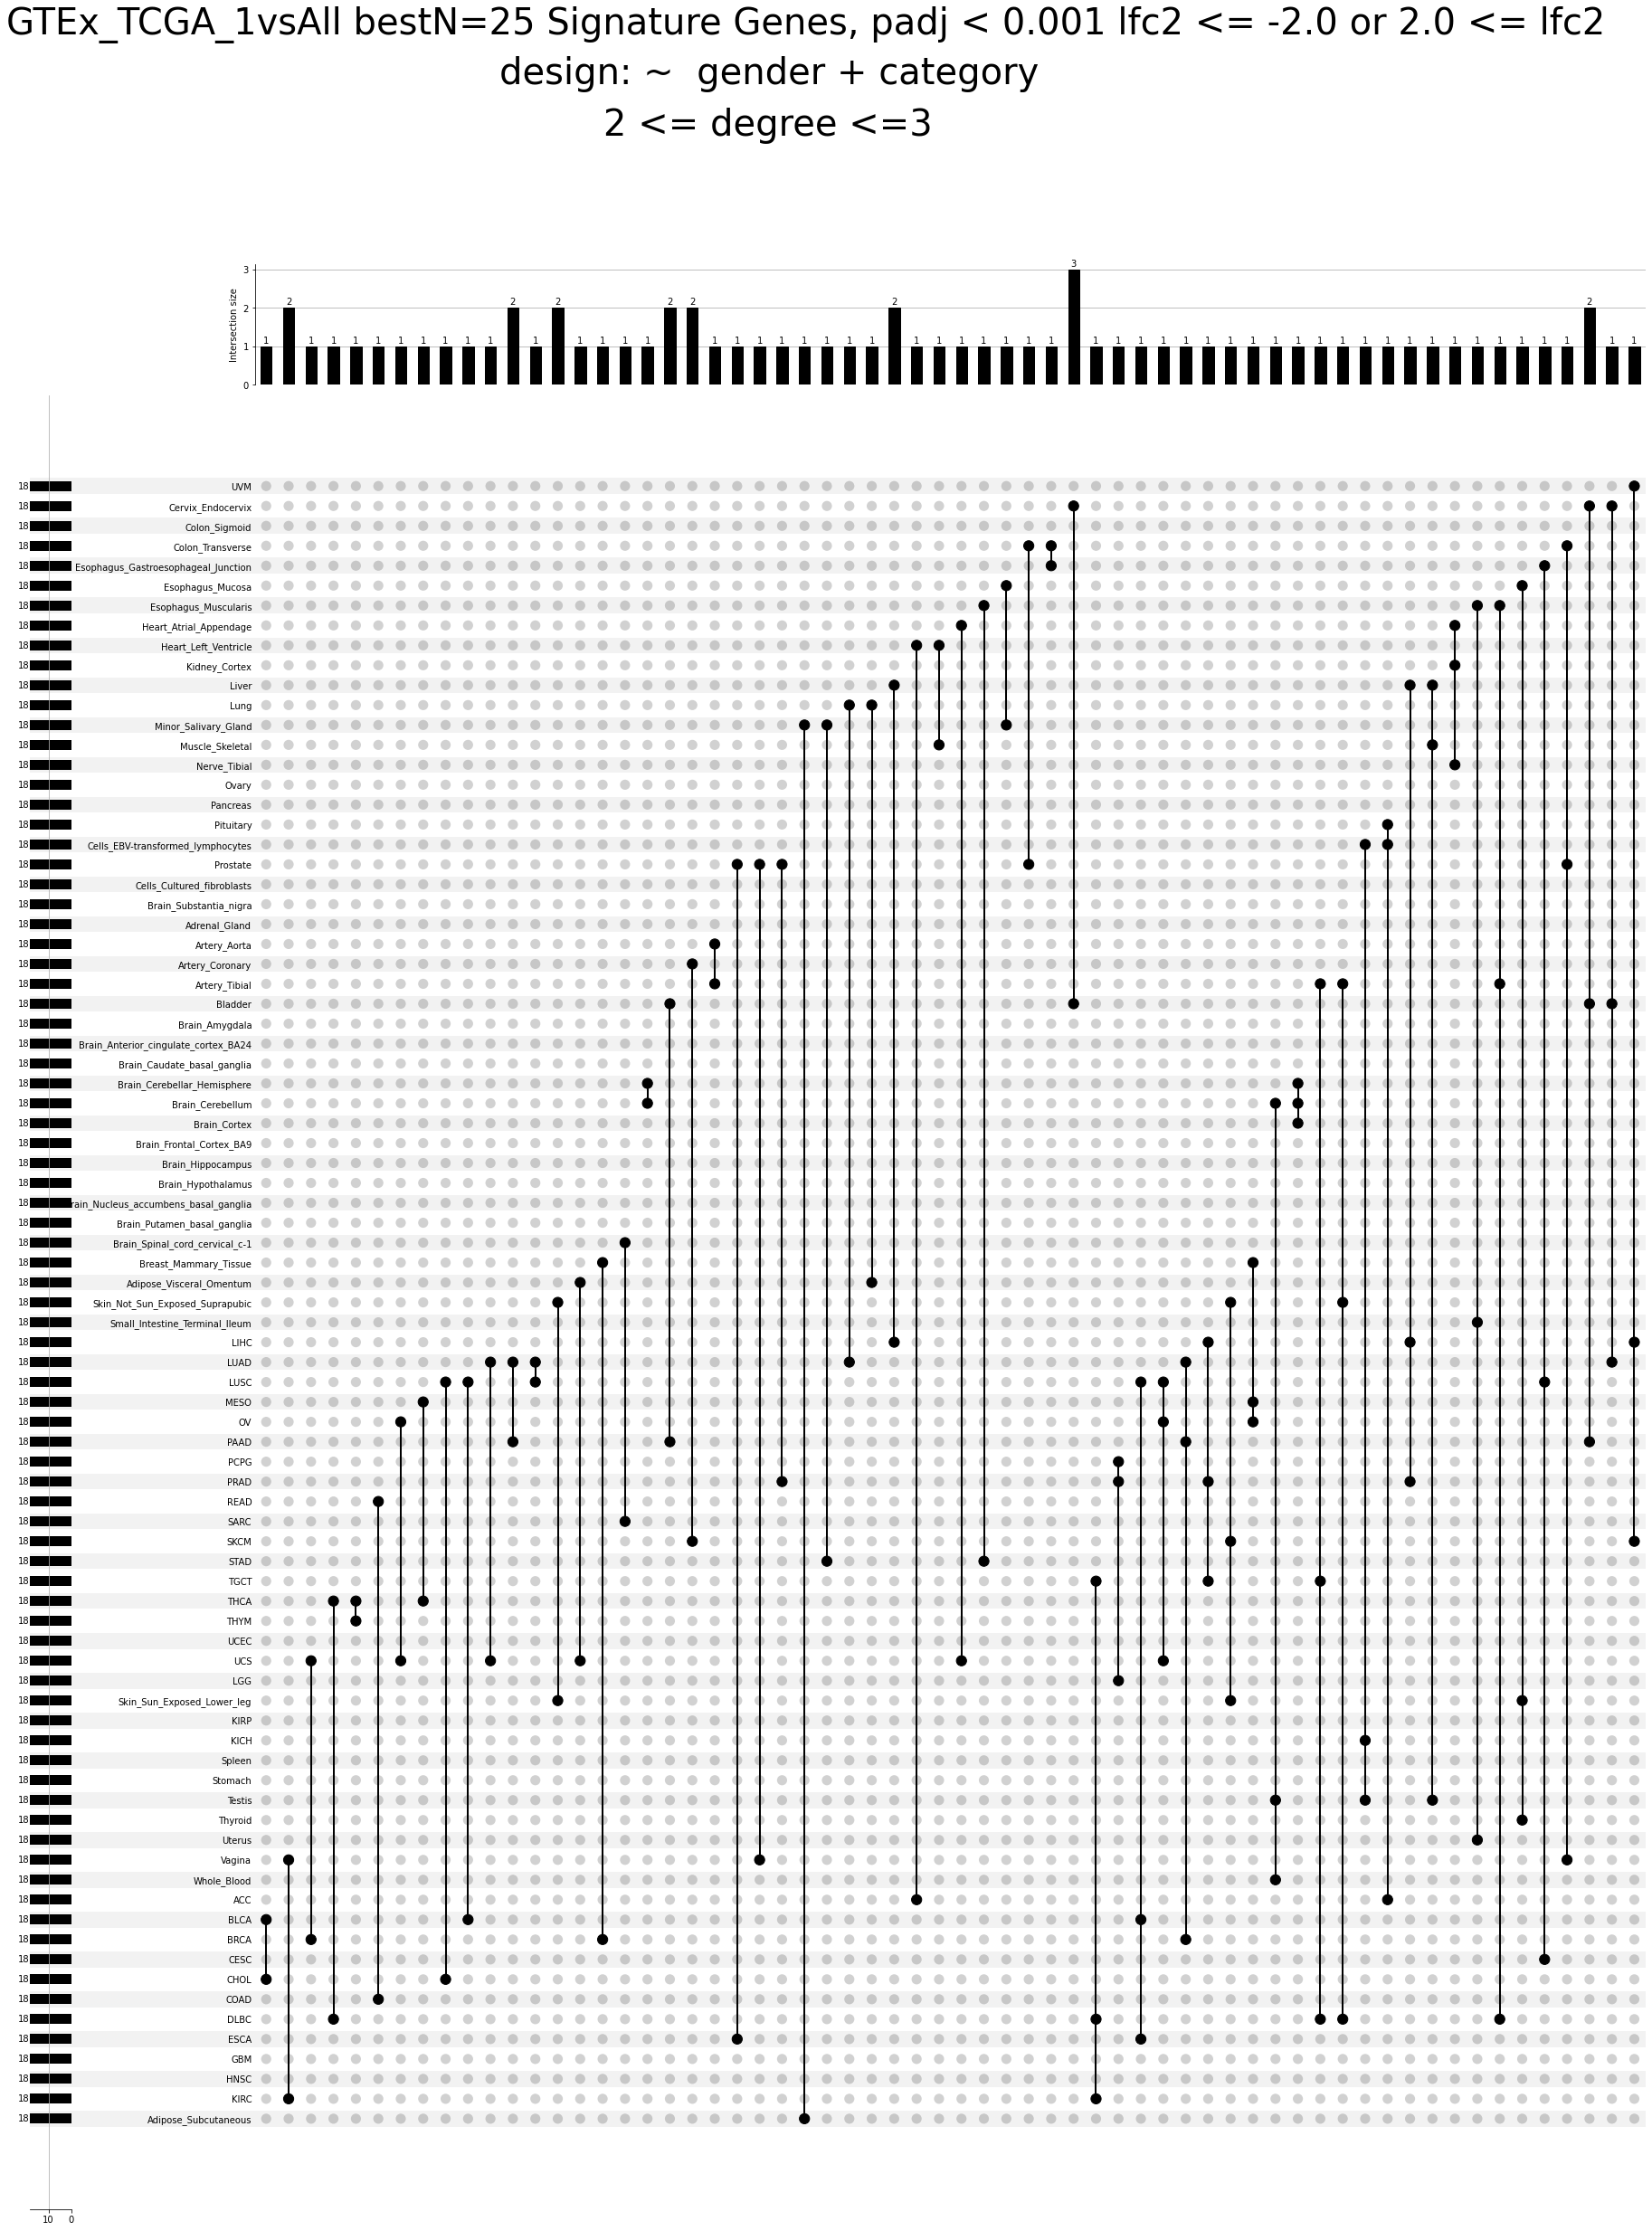

In [37]:
# create a plot of all interesections composed of 4 or more sets
# use extra args to insure saved file name is unique
extraFileNameParts = 'min_degree=2,max_degree=3'
fig, pltDict = configurablePlot(signatureGeneConfig, geneSetsUpsetPlotData, show_counts=True, min_degree=2, max_degree=3)

# add more text to plot
designStr = "design: {}".format(signatureGeneConfig.design)
# hack to find text positions
fig.text(x=0.35, y=0.95, s=designStr, fontsize=40 )
fig.text(x=0.40, y=0.93, s="2 <= degree <=3", fontsize=40)

savePlot(fig, signatureGeneConfig, extraFileNameParts)

### upset plot: min_degree = 2 max_degree = 3 interesections elements

In [38]:
def testFunction(key):
    return key >= 2 and key <= 3
                
printInserectionElements(setDegreesDict, testFunction)


############### degree: 3 number of intersections:25

setName:Artery_Tibial,DLBC,Esophagus_Muscularis
 elements:
{'CALD1'}

setName:Artery_Tibial,DLBC,TGCT
 elements:
{'RHOB'}

setName:Artery_Tibial,DLBC,Skin_Not_Sun_Exposed_Suprapubic
 elements:
{'TNS1', 'MGP'}

setName:Bladder,Cervix_Endocervix,PAAD
 elements:
{'TUBB4A', 'NDRG4'}

setName:Bladder,Cervix_Endocervix,LUAD
 elements:
{'SNAP25'}

setName:Brain_Cerebellar_Hemisphere,Brain_Cerebellum,Brain_Cortex
 elements:
{'HLA-C', 'IGHG1', 'COL1A2', 'IGKC', 'KRT5', 'HLA-A', 'TAGLN', 'RPLP0', 'CD74', 'AHNAK', 'TXNIP', 'HLA-B'}

setName:Brain_Cerebellum,Testis,Whole_Blood
 elements:
{'COL1A1', 'HLA-B', 'AHNAK', 'B2M'}

setName:Breast_Mammary_Tissue,MESO,OV
 elements:
{'ATP1A2', 'SFN', 'PKP1', 'SDC1'}

setName:ACC,Cells_EBV-transformed_lymphocytes,Pituitary
 elements:
{'GLUL', 'TAGLN', 'IGHG1', 'COL1A2'}

setName:Cells_EBV-transformed_lymphocytes,KICH,Testis
 elements:
{'VIM', 'IGHG1', 'FLNA', 'KRT5', 'COL1A1', 'TAGLN', 'DES'}

setName:Col

###  upset plot: min_degree = 4 

rm: cannot remove 'output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=4.png': No such file or directory
saving to: output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=4.png
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best-sortedByBaseMean/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=4.png
Copying file://output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=4.png [Content-Type=image/png]...
/ [1 files][  5.7 MiB/  5.7 MiB]                                                
Operation completed over 1 objects/5.7 MiB.                                      


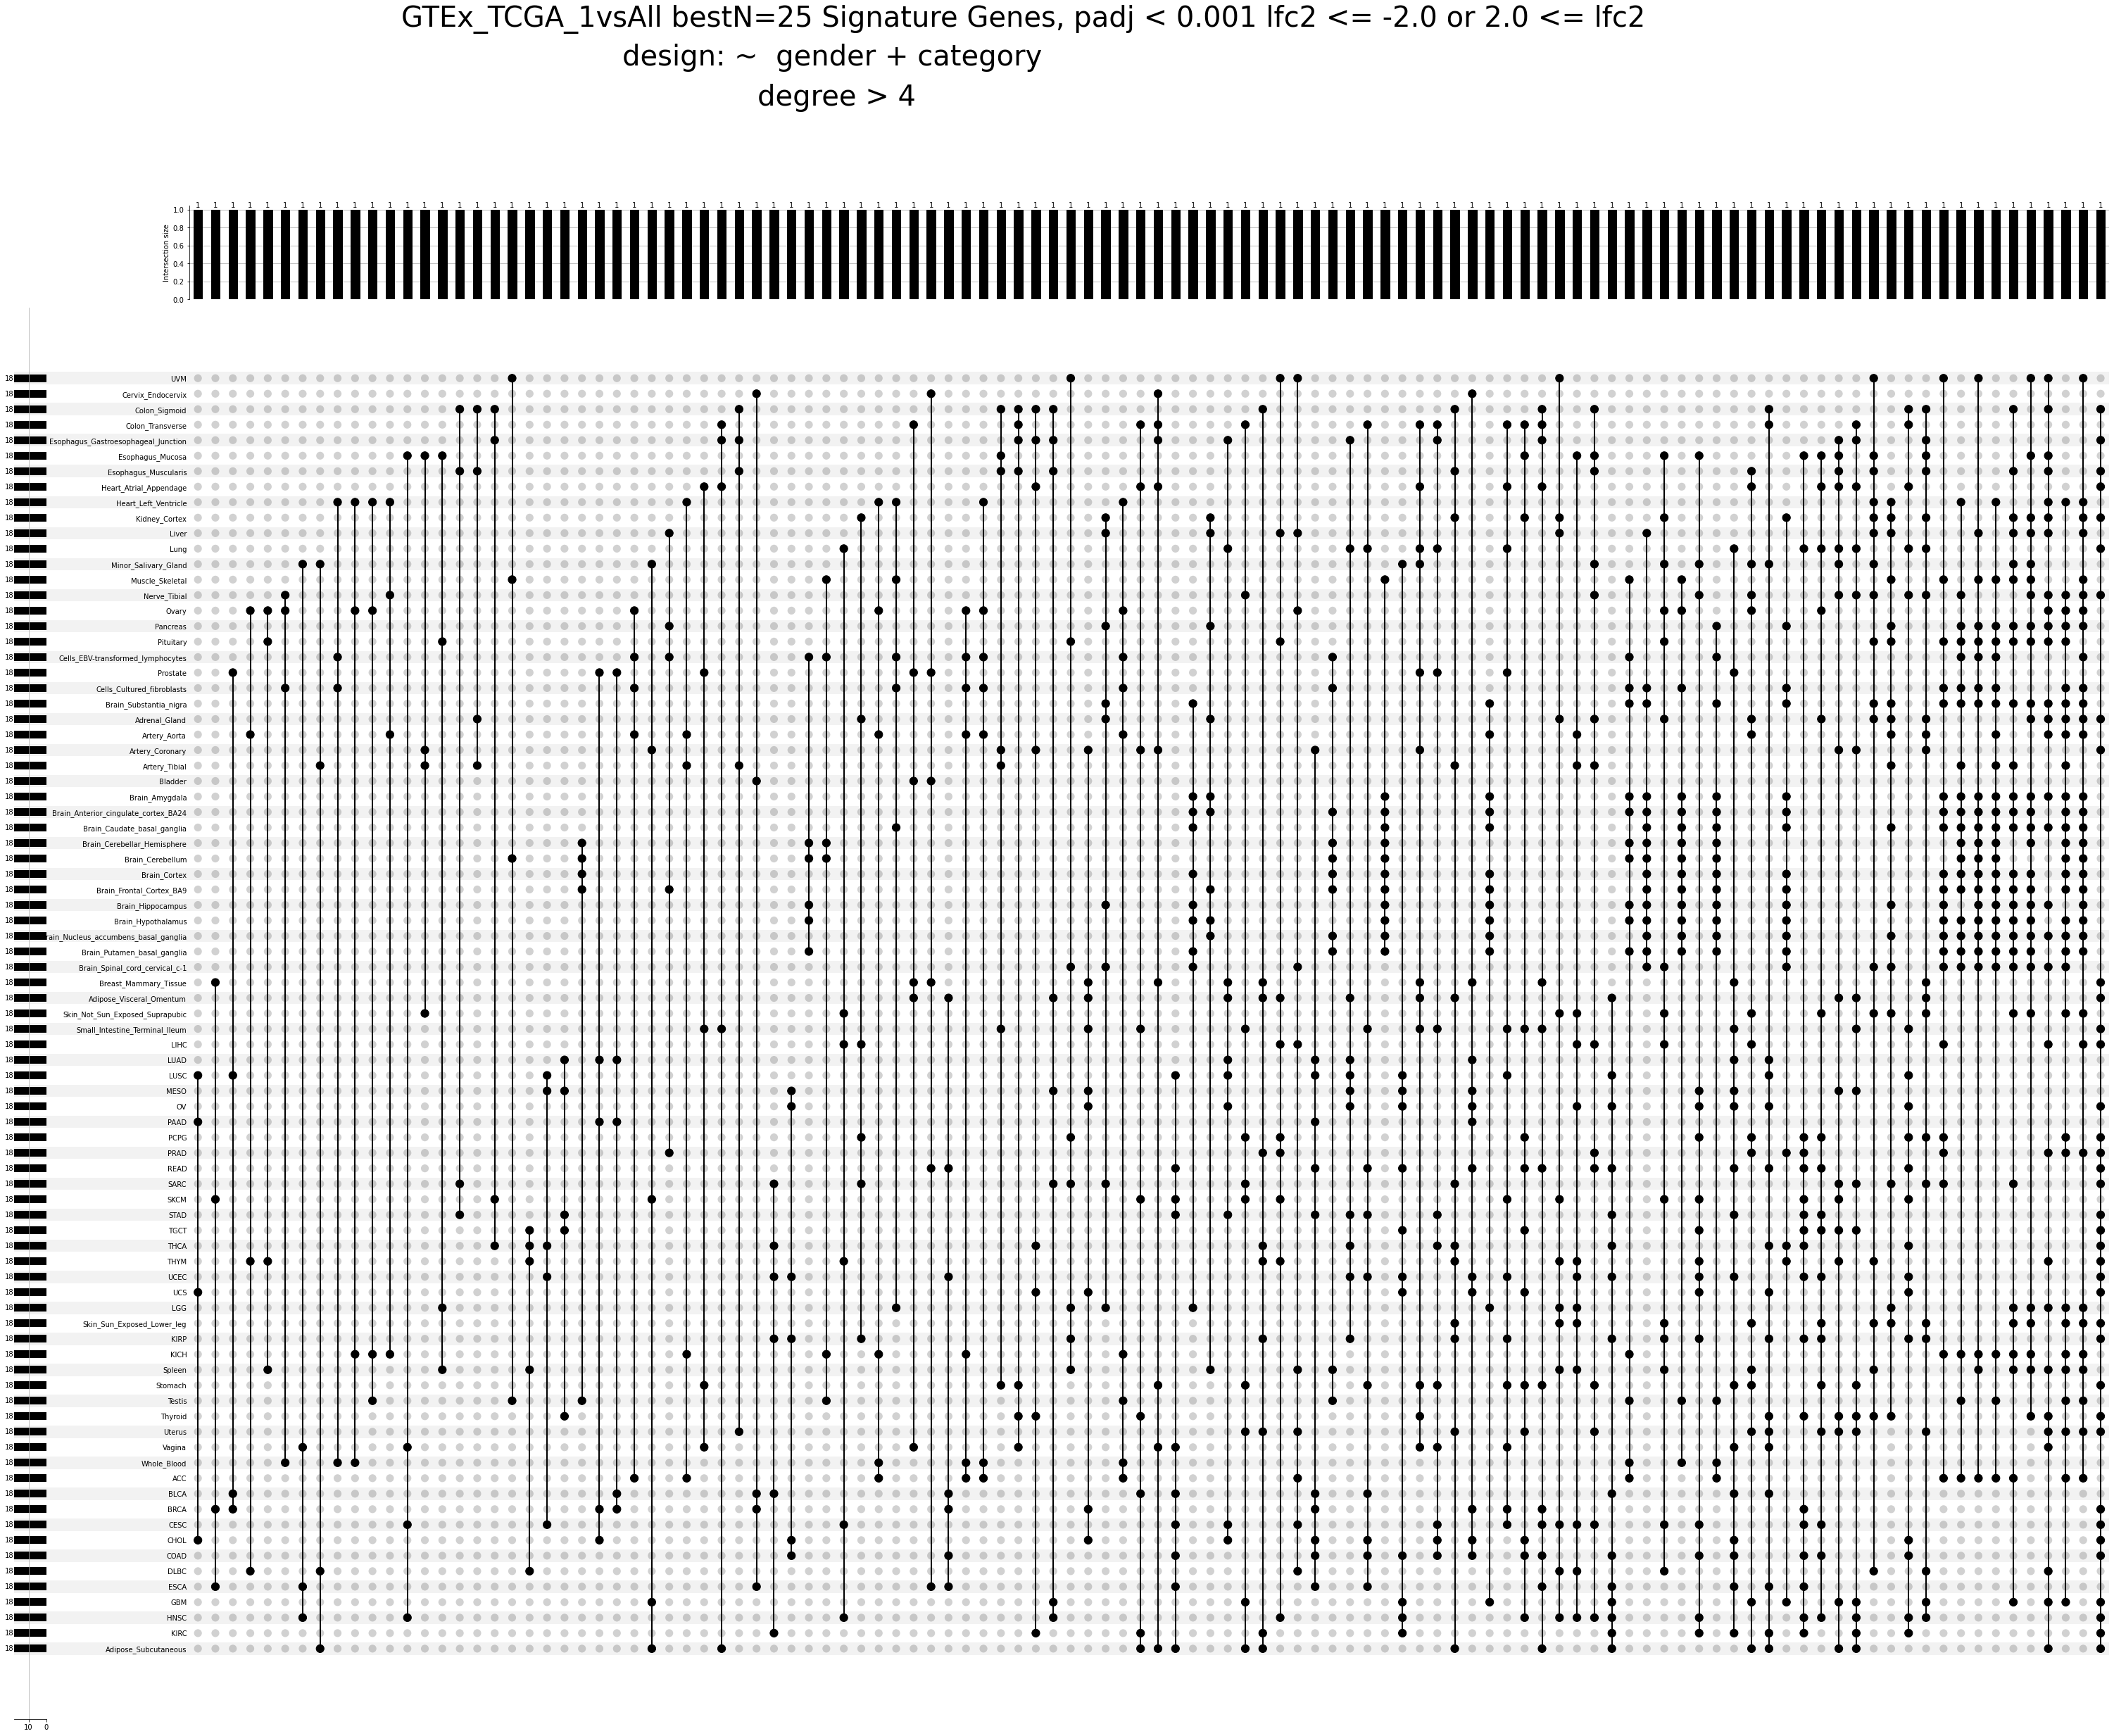

In [39]:
# create a plot of all interesections composed of 4 or more sets
# use extra args to insure saved file name is unique
extraFileNameParts = 'min_degree=4'
fig, pltDict = configurablePlot(signatureGeneConfig, geneSetsUpsetPlotData, show_counts=True, min_degree=4)

# add more text to plot
designStr = "design: {}".format(signatureGeneConfig.design)
# hack to find text positions
fig.text(x=0.35, y=0.95, s=designStr, fontsize=40 )
fig.text(x=0.40, y=0.93, s="degree > 4", fontsize=40)


savePlot(fig, signatureGeneConfig, extraFileNameParts)

###  upset plot: min_degree = 4  interesections elements

In [40]:
def testFunction(key):
    return key >= 4
                
printInserectionElements(setDegreesDict, testFunction)                


############### degree: 37 number of intersections:1

setName:Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Coronary,BRCA,Breast_Mammary_Tissue,CESC,CHOL,COAD,Colon_Sigmoid,Esophagus_Gastroesophageal_Junction,Esophagus_Muscularis,GBM,HNSC,Heart_Atrial_Appendage,KIRC,KIRP,Kidney_Cortex,LIHC,Lung,Nerve_Tibial,OV,PCPG,PRAD,READ,SARC,STAD,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Stomach,TGCT,THCA,THYM,Thyroid,UCEC,UCS,Uterus
 elements:
{'KRT17'}

############### degree: 34 number of intersections:1

setName:ACC,Adrenal_Gland,Artery_Aorta,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,Brain_Cerebellum,Brain_Cortex,Brain_Frontal_Cortex_BA9,Brain_Hippocampus,Brain_Hypothalamus,Brain_Nucleus_accumbens_basal_ganglia,Brain_Putamen_basal_ganglia,Brain_Substantia_nigra,Cells_Cultured_fibroblasts,Cells_EBV-transformed_lymphocytes,Heart_Left_Ventricle,KICH,Kidney_Cortex,LGG,LIHC,Liver,Muscle_Skeletal,